This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

We will start by covering the three most common 
use cases of neural networks— binary classification, multiclass classification,
and scalar regression:

*   Classifying movie reviews as positive or negative (binary classification)
*   Classifying news wires by topic (multiclass classification)
* Estimating the price of a house, given real-estate data (scalar regression)



## Classifying movie reviews: A binary classification example

Two-class  classification, or  binary  classification, is  one of  the  most  common  kinds of machine learning problems. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.



### The IMDB dataset

You'll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database.  They're  split  into  25,000  reviews  for  training  and  25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.


 Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has
already  been  preprocessed:  the  reviews  (sequences of words)  have been  turned  into sequences  of  integers,  where  each  integer  stands  for  a  specific  word  in  a  dictionary. This enables us to focus on model building, training, and evaluation.

The following code will load the dataset (when you run it the first time, about 80 MB of data will be downloaded to your machine).

**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` means you’ll only keep the top `10,000` most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size. If we didn't set this limit, we'd be working with `88,585` unique words in the training data, which is unnecessarily large.  Many of these words only occur in a single sample, and thus can't be meaningfully used for classification.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [2]:
import numpy as np
np.transpose(train_data[0])

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [3]:
train_labels[0]

1

Because  we're  restricting  ourselves  to  the  top `10,000`  most  frequent  words, no word index will exceed `10,000`:

In [4]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here’s how you can quickly decode one of these reviews back to English words.

**Decoding reviews back to text**

In [5]:
word_index = imdb.get_word_index()                                              # word_index is a dictionary mapping words to an integer index.
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])                      # Reverses it, mapping integer indices to words.
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])                # Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 
                                                                                # are reserved indices for padding, start of sequence, and unknown.

1641221/1641221 [==============================] - 0s 0us/step


In [6]:
# Print out the English text from the decoded review
print(decoded_review[2:])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think

### Preparing the data

You can't directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

*   Pad your lists so that they all have the same length, turn them into an integer tensor of shape (`samples`, `max_length`), and start your model with a layer capable of handling such integer tensors (the `Embedding layer`, which we'll cover in detail later in the book).
*   `Multi-hot  encode`  your  lists  to  turn  them  into  vectors  of  0s  and  1s.  This  would mean, for instance, turning the sequence [`8`, `5`] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a  `Dense` layer, capable  of handling floating-point vector data,  as the first layer in your model.

We will  go  with  the  latter  solution  to  vectorize  the  data,  which  we can do  manually  for maximum clarity.


**Encoding the integer sequences via multi-hot encoding**

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))                             # Creates an all-zero matrix of shape (len(sequences), dimension).
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1                                                   # Sets specific indices of results[i] to 1s.
    return results
x_train = vectorize_sequences(train_data)                                       # Vectorized training data
x_test = vectorize_sequences(test_data)                                         # Vectorized test data

Here’s what the samples look like now:

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

You should also vectorize your labels, which is straightforward:

In [9]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Now the data is ready to be fed into a neural network. 

### Building your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you'll ever encounter. A type of model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with `relu` activations.

There are two key architecture decisions to be made about such a stack of Dense
layers:

*   How many layers to use
*   How many units to choose for each layer

For the time being, we will make the following architecture
choices:

*  Two intermediate layers with 16 units each
*  A third layer that will output the scalar prediction  regarding  the  sentiment  of  the current review

Visually, the three layer model can be represented by:

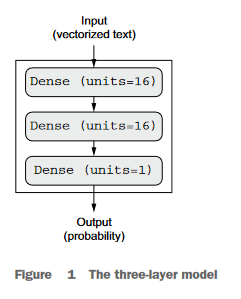

We will now show the Keras implementation.



**Model definition**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    # TODO - What should the activation function be here?
    layers.Dense(1, activation="sigmoid")
])

The  first  argument  being  passed  to  each  Dense  layer  is  the  number  of  units  in  the layer:  the  dimensionality  of  representation  space  of  the  layer.  You  can recall that each such Dense layer with a relu activation implements the following chain of tensor operations:

`output = relu(dot(input, W) + b)`

Having 16 units means the weight matrix W will have shape (input_dimension, 16):
the dot product with W will project the input data onto a 16-dimensional representation space (and then you'll add the bias vector b and apply the relu operation). You can  intuitively  understand  the  dimensionality  of  your  representation  space  as  “how much freedom you're allowing the model to have when learning internal representations.”  Having  more  units  (a higher-dimensional  representation  space)  allows  your model to learn more-complex representations, but it makes the model more computationally  expensive  and  may  lead  to  learning  unwanted  patterns  (patterns  that  will improve performance on the training data but not on the test data).

The  intermediate  layers  use `relu`  as  their  activation  function,  and  the  final  layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1 indicating how likely the sample is to have the target “1”: how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero out negative values (see figure 2), whereas a sigmoid “squashes” arbitrary values into the `[0, 1]` interval (see figure 3), outputting something that can be interpreted as a probability.

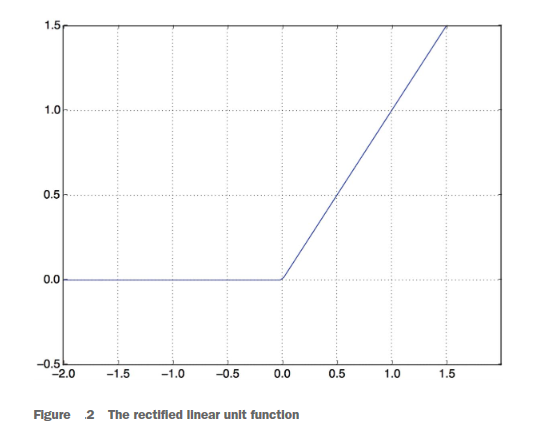

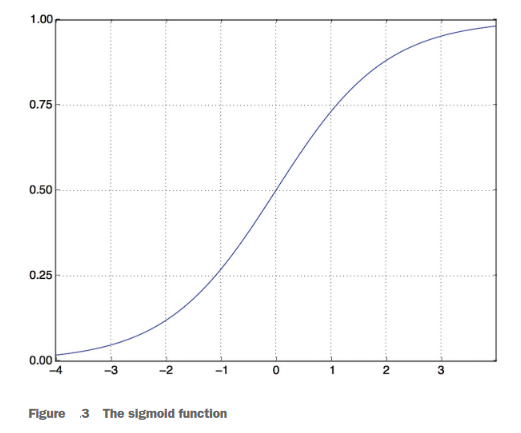

**What are activation functions, and why are they necessary?**


Without an activation function like `relu` (also called a non-linearity), the `Dense` layer would consist of two linear operations— a dot product and an addition:

`output = dot(input, W) + b`

The layer could only learn linear transformations (affine transformations) of the input data: the hypothesis space of the layer would be the set of all possible linear transformations of the input data into a 16-dimensional space. Such a hypothesis space is  too  restricted  and  wouldn't  benefit  from  multiple  layers  of  representations, because a deep stack of linear layers would still implement a linear operation: adding more layers wouldn't extend the hypothesis space.

In order to get access to a much richer hypothesis space that will benefit from deep representations, you need a  non-linearity, or activation function. `relu` is  the  most popular activation  function  in deep learning,  but there are many other candidates, which all come with similarly strange names: `prelu`, `elu`, and so on.

Finally, you need to choose a loss function and an optimizer. Because you're facing a binary classification problem and the output of your model is a probability (you end your  model  with  a  single-unit  layer  with  a  sigmoid  activation),  it's  best  to  use  the `binary_crossentropy` loss. It isn't the only viable choice: for instance, you could use
`mean_squared_error`. But crossentropy is usually the best choice when you're dealing with models that output probabilities. Crossentropy is a quantity from the field of information theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

As for the choice of the optimizer, we'll go with `rmsprop`, which is a usually a good default choice for virtually any problem.

Here’s  the step  where  we  configure  the  model  with  the rmsprop  optimizer and the `binary_crossentropy` loss function. Note that we'll also monitor accuracy during training.

**Compiling the model**

In [11]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

A deep learning model should never be evaluated on its
training data— it's standard practice to use a validation set to monitor the accuracy of the model during training. Here, we'll create a validation set by setting apart 10,000 samples from the original training data.

**Setting aside a validation set**

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples. At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart. We do so by passing the validation data as the `validation_data` argument.

**Training your model**

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 69ms/step - loss: 0.5269 - accuracy: 0.7731 - val_loss: 0.3919 - val_accuracy: 0.8676
Epoch 2/20
30/30 [==============================] - 2s 53ms/step - loss: 0.3187 - accuracy: 0.8963 - val_loss: 0.3156 - val_accuracy: 0.8822
Epoch 3/20
30/30 [==============================] - 2s 59ms/step - loss: 0.2364 - accuracy: 0.9201 - val_loss: 0.2923 - val_accuracy: 0.8843
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1901 - accuracy: 0.9353 - val_loss: 0.2762 - val_accuracy: 0.8887
Epoch 5/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1581 - accuracy: 0.9486 - val_loss: 0.2793 - val_accuracy: 0.8869
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1353 - accuracy: 0.9580 - val_loss: 0.2866 - val_accuracy: 0.8864
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1137 - accuracy: 0.9652 - val_loss: 0.2995 - val_accuracy: 0.8855
Epoch 8/20
30

On CPU, this will take less than 2 seconds per epoch—training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a History object.
This object has a member history, which is a dictionary containing data about everything that happened during training. Let's look at it:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation. In the following two listings, let's use Matplotlib to plot the training and validation loss side by side (see figure below), as well as the training and validation accuracy. 

Note that your own results may vary slightly due to
a different random initialization of your model.

**Plotting the training and validation loss**

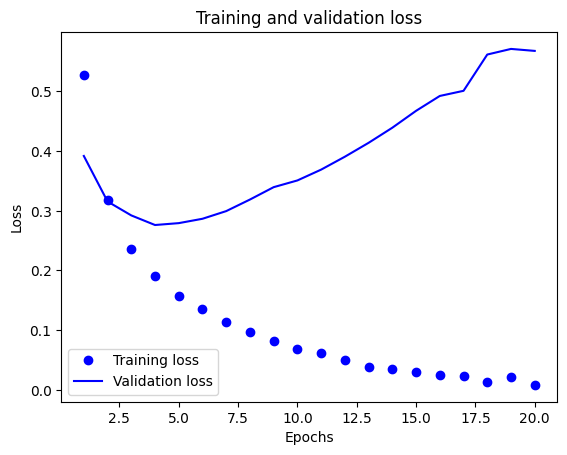

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")                      # 'bo' is for a solid blue dot
plt.plot(epochs, val_loss_values, "b", label="Validation loss")                 # 'b' is for a solid blue line.
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

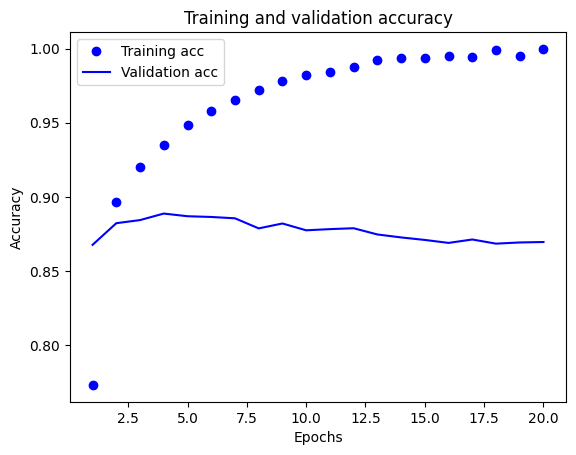

In [16]:
plt.clf()                                                                       # Clears the figure
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**What went wrong?**

As you can see, the training loss decreases with every epoch, and the training accuracy increases  with  every  epoch.  That's  what  you  would  expect  when  running  gradient-descent  optimization— the  quantity  you're  trying  to  minimize  should  be  less  with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak  at  the  fourth  epoch.  

This  is  an  example  of  what  can often happen:  a model  that  performs  better  on  the  training  data  isn't  necessarily  a  model  that  will
do  better  on  data  it  has  never  seen  before.  In  precise  terms,  what  you're  seeing  is **overfitting**: after the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don't generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after four epochs.  In general, you can use a range of techniques to mitigate overfitting.

Let's train a new model from scratch for four epochs and then evaluate it on the
test data.

**Retraining a model from scratch**

In [17]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 36ms/step - loss: 0.4554 - accuracy: 0.8145
Epoch 2/4
49/49 [==============================] - 2s 37ms/step - loss: 0.2673 - accuracy: 0.9048
Epoch 3/4
49/49 [==============================] - 1s 25ms/step - loss: 0.2095 - accuracy: 0.9256
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2879 - accuracy: 0.8858


The final results are as follows:

In [18]:
print("Test loss : %.2f, Test accuracy : %5.2f" % (results[0], results[1]))

Test loss : 0.29, Test accuracy :  0.89


This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, you should be able to get close to 95%.

### Using a trained model to generate predictions on new data

After having trained a model, you’ll want to use it in a practical setting. You can generate  the  likelihood  of  reviews  being  positive  by  using  the  predict  method:

In [19]:
model.predict(x_test)

782/782 [==============================] - 2s 3ms/step


array([[0.23427148],
       [0.9995674 ],
       [0.7799575 ],
       ...,
       [0.09693278],
       [0.09130719],
       [0.7253075 ]], dtype=float32)

As  you  can  see,  the  model  is  confident  for  some  samples  (0.99  or  more,  or  0.01  or less) but less confident for others (0.6, 0.4). 

### Further experiments

The following experiments will help convince you that the architecture choices you've made are all fairly reasonable, although there's still room for improvement:

* You used two representation layers before the final classification layer. Try using
one or three representation layers, and see how doing so affects validation and
test accuracy.
* Try using layers with more units or fewer units: `32` units, `64` units, and so on.
* Try using the `mse` loss function instead of `binary_crossentropy`.
* Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

### Wrapping up

Here's what you should take away from this example:
* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can
be encoded as binary vectors, but there are other encoding options too.
* Stacks of `Dense` layers with relu activations can solve a wide range of problems (including sentiment classification), and you'll likely use them frequently.
* In a binary classification problem (two output classes), your model should end
with  a  Dense  layer  with  one  unit  and  a sigmoid  activation:  the  output  of  your model should be a scalar between 0 and 1, encoding a probability.
* With  such  a  scalar  sigmoid  output  on  a  binary  classification  problem,  the  loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice, whatever your prob-
lem. That's one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting  and  end  up  obtaining  increasingly  worse  results  on  data  they've  never seen before. Be sure to always monitor performance on data that is outside of the training set. 

## Classifying newswires: A multiclass classification example

In the previous section, you saw how to classify vector inputs into two mutually exclusive  classes  using  a  densely  connected  neural  network.  But  what  happens  when  you have more than two classes?

In this section, we'll build a model to classify Reuters newswires into 46 mutually exclusive  topics.  Because  we  have  many  classes,  this  problem  is  an  instance  of  `multi-class classification`, and because each data point should be classified into only one category, the problem is more specifically an instance of `single-label multiclass classification`.

If each data point could belong to multiple categories (in this case, topics), we'd be facing a `multilabel multiclass classification problem`.

### The Reuters dataset

We'll work with the `Reuters dataset`, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

 Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's
take a look.

**Loading the Reuters dataset**

In [20]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


As  with  the  IMDB  dataset,  the  argument  num_words=10000  restricts  the  data  to  the 10,000 most frequently occurring words found in the data.

You have 8,982 training examples and 2,246 test examples:

In [21]:
len(train_data)

8982

In [22]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [23]:
np.array(train_data[10])

array([   1,  245,  273,  207,  156,   53,   74,  160,   26,   14,   46,
        296,   26,   39,   74, 2979, 3554,   14,   46, 4689, 4329,   86,
         61, 3499, 4795,   14,   61,  451, 4329,   17,   12])

Here’s how you can decode it back to words, in case you're curious.

**Decoding newswires back to text**

In [24]:
word_index = reuters.get_word_index()
# TODO - What should go here?
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in        # Note that the indices are offset by 3 because 0, 1, and 2 are 
    train_data[0]])                                                             # reserved indices for padding, start of sequence, and unknown.

550378/550378 [==============================] - 0s 0us/step


In [25]:
# Print out the English text from the decoded newswire
print(decoded_newswire[3:])

 ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


The label associated with an example is an integer between 0 and 45— a topic index:

In [26]:
train_labels[14]

19

### Preparing the data

You can vectorize the data with the exact same code as in the previous example.

**Encoding the input data**

In [27]:
x_train = vectorize_sequences(train_data)                                       # Vectorized training data
x_test = vectorize_sequences(test_data)                                         # Vectorized test data

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use `one-hot encoding`. One-hot encoding is a widely used format for  categorical  data,  also called `categorical  encoding`. In  this case, one-hot  encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. The following listing shows an example.

**Encoding the labels**

In [28]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)                                              # Vectorized training labels
y_test = to_one_hot(test_labels)                                                # Vectorized test labels

Note that there is a built-in way to do this in Keras:

In [29]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, we're trying to classify short snippets of text. But there is a  new  constraint  here:  the  number  of  output  classes  has  gone  from  2  to  46.  The dimensionality of the output space is much larger.

In a stack of `Dense` layers like those we've been using, each layer can only access information  present  in  the  output  of  the  previous  layer.  If  one  layer  drops  some information  relevant  to  the  classification  problem,  this  information  can  never  be recovered by later layers: each layer can potentially become an information bottle-neck.  In  the previous  example, we used 16-dimensional intermediate  layers, but  a 16-dimensional  space  may  be  too  limited  to  learn  to  separate  46  different  classes:
such  small  layers  may  act  as  information  bottlenecks,  permanently  dropping  relevant information.

For this reason we'll use larger layers. Let's go with 64 units.

**Model definition**

In [30]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    # TODO - What should the activation function be here?
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In [31]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [32]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [33]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 64ms/step - loss: 2.7020 - accuracy: 0.4902 - val_loss: 1.8712 - val_accuracy: 0.6190
Epoch 2/20
16/16 [==============================] - 1s 49ms/step - loss: 1.5409 - accuracy: 0.6844 - val_loss: 1.3936 - val_accuracy: 0.7020
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 1.1750 - accuracy: 0.7427 - val_loss: 1.1963 - val_accuracy: 0.7290
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.9566 - accuracy: 0.7900 - val_loss: 1.0881 - val_accuracy: 0.7630
Epoch 5/20
16/16 [==============================] - 1s 49ms/step - loss: 0.7942 - accuracy: 0.8236 - val_loss: 1.0217 - val_accuracy: 0.7700
Epoch 6/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6608 - accuracy: 0.8537 - val_loss: 0.9465 - val_accuracy: 0.8020
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5545 - accuracy: 0.8766 - val_loss: 0.9102 - val_accuracy: 0.8060
Epoch 8/20
16

**Plotting the training and validation loss**

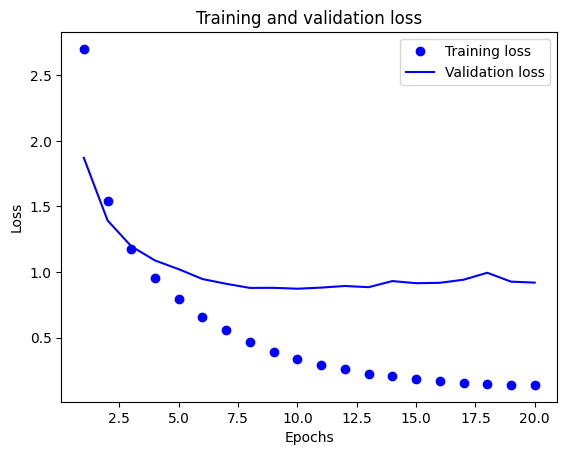

In [34]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

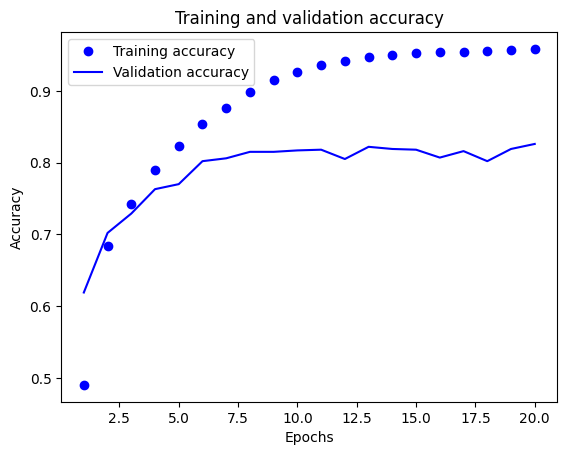

In [35]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [36]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 3s 60ms/step - loss: 2.5596 - accuracy: 0.5105
Epoch 2/9
18/18 [==============================] - 1s 42ms/step - loss: 1.4708 - accuracy: 0.6888
Epoch 3/9
18/18 [==============================] - 1s 43ms/step - loss: 1.1223 - accuracy: 0.7522
Epoch 4/9
18/18 [==============================] - 1s 41ms/step - loss: 0.9072 - accuracy: 0.8059
Epoch 5/9
18/18 [==============================] - 1s 45ms/step - loss: 0.7433 - accuracy: 0.8383
Epoch 6/9
18/18 [==============================] - 1s 44ms/step - loss: 0.6153 - accuracy: 0.8654
Epoch 7/9
18/18 [==============================] - 1s 42ms/step - loss: 0.5080 - accuracy: 0.8913
Epoch 8/9
18/18 [==============================] - 2s 87ms/step - loss: 0.4231 - accuracy: 0.9100
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9746 - accuracy: 0.7814


In [37]:
results

[0.974608838558197, 0.7813891172409058]

In [38]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1923419412288513

### Generating predictions on new data

In [39]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


In [40]:
predictions[0].shape

(46,)

In [41]:
np.sum(predictions[0])

0.99999994

In [42]:
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

In [43]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [44]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [45]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 3s 31ms/step - loss: 3.2978 - accuracy: 0.2308 - val_loss: 2.8574 - val_accuracy: 0.2540
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 2.5428 - accuracy: 0.2788 - val_loss: 2.3268 - val_accuracy: 0.2810
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8935 - accuracy: 0.3951 - val_loss: 1.6440 - val_accuracy: 0.6270
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.2772 - accuracy: 0.7085 - val_loss: 1.3642 - val_accuracy: 0.6910
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0823 - accuracy: 0.7491 - val_loss: 1.3143 - val_accuracy: 0.6980
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9799 - accuracy: 0.7704 - val_loss: 1.3028 - val_accuracy: 0.7100
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9018 - accuracy: 0.7888 - val_loss: 1.2887 - val_accuracy: 0.7090
Epoch 8/20
63

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [46]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [47]:
train_data.shape

(404, 13)

In [48]:
test_data.shape

(102, 13)

In [49]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [50]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [51]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [52]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [53]:
all_scores

[2.329153299331665, 2.398811101913452, 2.4628353118896484, 2.338761568069458]

In [54]:
np.mean(all_scores)

2.382390320301056

**Saving the validation logs at each fold**

In [55]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [56]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

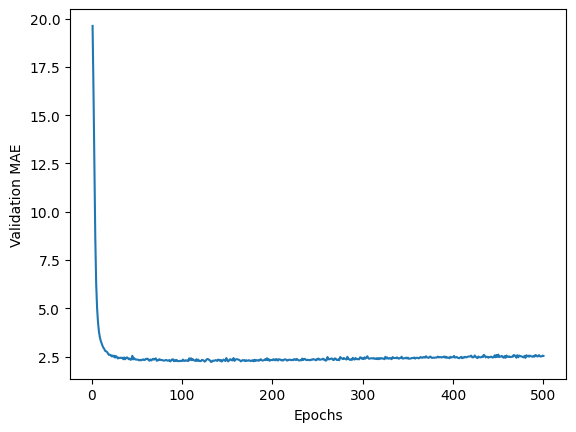

In [57]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

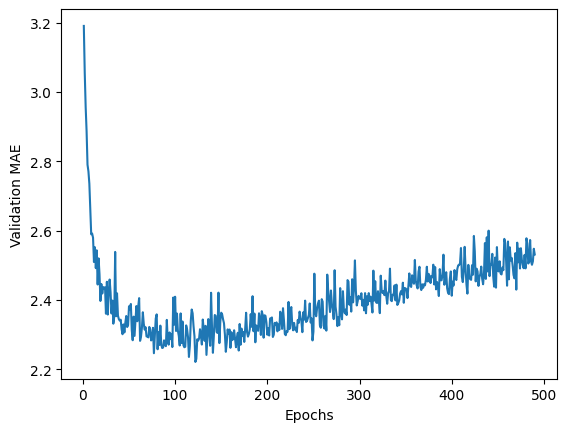

In [58]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [59]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 19.6394 - mae: 3.0106


In [60]:
test_mae_score

3.0106027126312256

### Generating predictions on new data

In [61]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 1s 3ms/step


array([10.572732], dtype=float32)

### Wrapping up

## Summary